# Pytorch Tabular
Notebook pensando para facilitar e agiliar o treinamento de Deep Learning, sendo necessário, em grande parte das vezes, somente alterar o caminho do dataset e o tipo (classificador ou regressão). Assim como, quais arquiteturas serão utilizado para buscar os melhores hiperparâmetros.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import math
import json

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Pytorch Tabular
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

## Preparar Dataset

In [2]:
def preprocess_data(df, target_cols, max_unique_values=10, window_size=1, no_columns_lags=[]):
    """
    Preprocess dataset, converting string columns to number and identifying numeric, categorical, and date columns.
    Adds a window of historical rows to the data.

    Args:
        df (DataFrame): DataFrame with data to analyze.
        target_cols (list): All target columns to not add in numeric, categorical, or date feature lists.
        max_unique_values (int): Maximum number of unique values to consider a numeric column as categorical.
        window_size (int): Number of previous rows to include for each row.
        no_columns_lags (list): Columns names to not do lags, keeping only the current one.

    Returns:
        df_copy (DataFrame): Processed DataFrame with transformations applied.
        num_col_names (list): List of numeric feature column names.
        cat_col_names (list): List of categorical feature column names.
        date_col_names (list): List of date feature column names.
        mappings (dict): Mapping of original categorical values (or target columns) to transformed numeric values.
    """
    # Create a copy so as not to alter the original DataFrame
    df_copy = df.copy()

    # Remove lines with null values
    df_copy = df_copy.dropna()
    
    # Identify categorical and numeric columns
    cat_col_names = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    num_col_names = df_copy.select_dtypes(include=['number']).columns.tolist()
    date_col_names = []

    # Identify columns that are dates
    for col in df.columns:
        if df[col].dtype in ['object', 'string']:  # Only check object/string columns
            try:
                # Attempt to convert the column to datetime
                df_copy[col] = pd.to_datetime(df[col], errors='raise')
                date_col_names.append(col)
            except (ValueError, TypeError):
                pass

    # Identify numeric columns that are categorical
    potential_categorical = []
    for col in num_col_names:
        if col and df_copy[col].nunique() <= max_unique_values:
            potential_categorical.append(col)

    cat_col_names += potential_categorical

    # Remove target columns from the lists
    num_col_names = [col for col in num_col_names if col not in potential_categorical + date_col_names]
    cat_col_names = [col for col in cat_col_names if col not in date_col_names]
    date_col_names = [col for col in date_col_names if col not in num_col_names + cat_col_names]
    
    mappings = {}
    label_encoders = {}

    # Convert string columns to category and create a mapping (old value -> new value)
    for col in cat_col_names:
        if df_copy[col].dtype not in ['int64', 'float64']:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col])
            mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
            label_encoders[col] = le
            # Convert values to int (otherwise will raise error if save as json)
            for key, value in mappings[col].items():
                mappings[col][key] = int(value)
        #else:
        #    mappings[col] = {int(val): int(val) for val in df_copy[col].unique()}

    # Remove target column as input
    for col in target_cols:
        if col in num_col_names:
            num_col_names.remove(col)
        if col in cat_col_names:
            cat_col_names.remove(col)
        if col in date_col_names:
            date_col_names.remove(col)
    
    # Add historical data based on window_size
    if window_size > 1:
        historical_features = []
        for i in range(window_size - 1, 0, -1):  # Create features lag, oldest to newest
            shifted = df_copy.drop(columns=no_columns_lags, errors='ignore').shift(i).add_suffix(f'_lag_{i}')
            historical_features.append(shifted)
        
        # Concatenate the lags to the left and keep the current values
        df_copy = pd.concat(historical_features + [df_copy], axis=1)

        # Remove NaNs columns created by shifts
        df_copy = df_copy.dropna()
    
        # Add lags
        num_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in num_col_names if col not in no_columns_lags]
        cat_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in cat_col_names if col not in no_columns_lags]
        date_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in date_col_names if col not in no_columns_lags]
        
        mappings_lags = {}
        for col, value in mappings.items():
            for i in range(window_size - 1, 0, -1):
                mappings_lags[f'{col}_lag_{i}'] = value
    
        # Update main columns + lags columns
        num_col_names = num_col_lags + num_col_names
        cat_col_names = cat_col_lags + cat_col_names
        date_col_names = date_col_lags + date_col_names

        mappings = {**mappings_lags, **mappings}
    
    return df_copy, num_col_names, cat_col_names, date_col_names, mappings

In [3]:
df = pd.read_csv('dataset/time_series_temperature.csv')
train_percentage = 0.7
model_type = 'regressor'  # classifier or regressor

# Temporal data
window_size = 3  # Greater than 1 for temporal data
no_columns_lags = ['date', 'target']  # Only for temporal data. Otherwise, keep the list empty

test_part = 2  # Which part of the dataset will be used to test. 0 == random; 1 == begin; 2 == end
target_cols = ['target']  # Target column
df

,date,temperature,atmospheric_pressure,humidity,wind_speed,target
0,2025-01-03,21.945101,985.302886,79.747740,3.849785,11.598255
1,2025-01-04,24.256379,992.558017,70.013222,3.537094,11.729554
2,2025-01-05,25.437674,1002.415965,85.906186,16.613512,10.067073
3,2025-01-06,26.343396,980.012419,73.849816,12.854979,11.774130
4,2025-01-07,15.172844,998.832892,82.972967,15.764626,7.019475
...,...,...,...,...,...,...
993,2027-09-23,28.037259,1011.984036,58.526246,19.503921,15.119683
994,2027-09-24,20.568564,1028.322144,41.765820,19.950369,13.642110
995,2027-09-25,12.500191,992.043538,41.860743,2.304613,9.617098
996,2027-09-26,24.722567,994.324767,34.068356,4.585596,12.473074


In [4]:
# Preprocess data
df, num_col_names, cat_col_names, date_col_names, category_mappings = preprocess_data(df, target_cols, max_unique_values=10, window_size=window_size, no_columns_lags=no_columns_lags)
col_names_order = df.columns.tolist()

In [5]:
print(f'''col_names_order: {col_names_order}
num_col_names: {num_col_names}
cat_col_names: {cat_col_names}
date_col_names: {date_col_names}
target_cols: {target_cols}
category_mappings: {category_mappings}''')

col_names_order: ['temperature_lag_2', 'atmospheric_pressure_lag_2', 'humidity_lag_2', 'wind_speed_lag_2', 'temperature_lag_1', 'atmospheric_pressure_lag_1', 'humidity_lag_1', 'wind_speed_lag_1', 'date', 'temperature', 'atmospheric_pressure', 'humidity', 'wind_speed', 'target']
num_col_names: ['temperature_lag_2', 'atmospheric_pressure_lag_2', 'humidity_lag_2', 'wind_speed_lag_2', 'temperature_lag_1', 'atmospheric_pressure_lag_1', 'humidity_lag_1', 'wind_speed_lag_1', 'temperature', 'atmospheric_pressure', 'humidity', 'wind_speed']
cat_col_names: []
date_col_names: ['date']
target_cols: ['target']
category_mappings: {}


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 2 to 997
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   temperature_lag_2           996 non-null    float64       
 1   atmospheric_pressure_lag_2  996 non-null    float64       
 2   humidity_lag_2              996 non-null    float64       
 3   wind_speed_lag_2            996 non-null    float64       
 4   temperature_lag_1           996 non-null    float64       
 5   atmospheric_pressure_lag_1  996 non-null    float64       
 6   humidity_lag_1              996 non-null    float64       
 7   wind_speed_lag_1            996 non-null    float64       
 8   date                        996 non-null    datetime64[ns]
 9   temperature                 996 non-null    float64       
 10  atmospheric_pressure        996 non-null    float64       
 11  humidity                    996 non-null    float64       
 12 

In [7]:
if model_type == 'classifier':
    print(df[target_cols].value_counts())

### Dataset Splitting

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Get random dates for the dataset for testing
if test_part == 0:
    train, test = train_test_split(df, random_state=42, test_size=1 - train_percentage)
# Get first part of the dataset for testing
elif test_part == 1:
    train = df.iloc[int((len(df) * (1 - train_percentage))):]
    train = shuffle(train, random_state=42)
    test = df.iloc[:int((len(df) * (1 - train_percentage)))]
# Get last part of the dataset for testing
elif test_part == 2:
    train = df.iloc[:int((len(df) * train_percentage))]
    train = shuffle(train, random_state=42)
    test = df.iloc[int((len(df) * train_percentage)):]

valid = test

## Train Pytorch Tabular
https://github.com/manujosephv/pytorch_tabular

### Preparar Configurações

No [DataConfig](https://pytorch-tabular.readthedocs.io/en/latest/data/#pytorch_tabular.config.DataConfig) estão as configurações do dataset, contendo as coluna no DataFrame Pandas que é o "target" (valor que será previsto), colunas que possuem dados continuos e de dados categóricos. Além de outras configurações que podem ser alteradas.

In [9]:
data_config = DataConfig(
    target=target_cols,  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,  # Column names of the numeric fields
    categorical_cols=cat_col_names,  # Column names of the categorical fields
    date_columns=date_col_names,  # (Column name, Freq, Format) tuples of the date fields. E.g. [("date", "M", %Y-%m')]. freq = https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    normalize_continuous_features=True, # Flag to normalize the input features (continuous). Default True
    encode_date_columns=False,
    num_workers=4
)

No [TrainerConfig](https://pytorch-tabular.readthedocs.io/en/latest/training/#using-the-entire-pytorch-lightning-trainer) estão as configurações de treinamento, incluindo quais métricas iremos utilizar para avaliar o modelo e criar os checkpoints

No [OptimizerConfig](https://pytorch-tabular.readthedocs.io/en/latest/optimizer/#pytorch_tabular.config.OptimizerConfig) estão as configurações do otimizado que será utilizador, sendo inclusive possível alterar seus parâmetros.

In [10]:
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate. Default False
    batch_size=64,
    max_epochs=300,
    min_epochs=50,
    early_stopping='valid_accuracy' if model_type == 'classifier' else 'valid_loss', # Monitor for early stopping. valid_loss or valid_accuracy
    early_stopping_mode = 'max' if model_type == 'classifier' else 'min', # Set the mode as min for val_loss (lower is better) and max for val_accuracy (higher is better)
    early_stopping_patience=20, # No. of epochs of degradation training will wait before terminating
    checkpoints='valid_accuracy' if model_type == 'classifier' else 'valid_loss', # Save best checkpoint monitoring
    checkpoints_mode='max' if model_type == 'classifier' else 'min',  # Set the mode as min for valid_loss (lower is better) and max for valid_accuracy (higher is better)
)

optimizer_config = OptimizerConfig(
    #optimizer='RMSprop',  # https://pytorch.org/docs/stable/optim.html#algorithms
    #optimizer_params={'alpha': 0.99},
    #lr_scheduler='StepLR',
    #lr_scheduler_params={'step_size': 10},
)

## Train Many Models
Entre tantas alternativas é difícil saber qual a melhora arquitetura utilizar, sem falar que muitas vezes uma arquitetura tem um desempenho muito bom em determinado assunto/dataset, mas isso não se mostra verdade entre outro cenário, dificultando escolher qual utilizar.

Para ajudar nesse dilema o Pytorch Tabular possui a função [model_sweep](https://pytorch-tabular.readthedocs.io/en/latest/apidocs_coreclasses/#pytorch_tabular.model_sweep) que roda todas as arquiteturas com os hiperpâmetros padrões e seu resultado consiste no comparativo entre todos eles. Dessa forma sabemos em qual/quais arquiteturas devemos investir mais tempo para buscar melhorar seus hiperparâmetros.

Vamos rodar a categoria "high_memory" que irá treinar todos modelos, inclusive os que utilizam bastante memória. Mas não se preocupe, se a memória não for suficiente a biblioteca irá ignorar o modelo e na tabela de resultados irá informar que não tinha memória suficiente (OOM). Ressaltando que pode ser interessante ter um batch_size pequeno para conseguir treinar todos os modelos sem resultar em OOM, ou rodar o modelo específico que deu OOM depois isoladamente com o batch_size que for suficiente :).

In [11]:
from pytorch_tabular import model_sweep, tabular_model_sweep

In [12]:
#tabular_model_sweep.MODEL_SWEEP_PRESETS

In [13]:
tic = time.time()
sweep_df, best_model = model_sweep(
    task='classification' if model_type == 'classifier' else 'regression',  # 'classification' or 'regression'
    train=train,
    test=valid,
    data_config=data_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    model_list='high_memory',  # The list of models to compare. This can be one of the presets defined in pytorch_tabular.tabular_model_sweep.MODEL_SWEEP_PRESETS or a list of ModelConfig objects. Defaults to "lite".
    verbose=True
)
print(f'Total time: {time.time() - tic}')

Output()

2025-06-07 09:34:21,507 - {pytorch_tabular:328} - INFO - Training AutoIntModel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:34:34,137 - {pytorch_tabular:382} - INFO - Finished Training AutoIntModel

2025-06-07 09:34:34,138 - {pytorch_tabular:383} - INFO - Results: model: AutoIntModel, # Params: 14 T, epochs: 87, 
test_loss: 0.030524782836437225, test_mean_squared_error: 0.030524782836437225, time_taken: 12.631255626678467,    
time_taken_per_epoch: 0.14518684628366055

2025-06-07 09:34:34,152 - {pytorch_tabular:328} - INFO - Training CategoryEmbeddingModel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:34:54,676 - {pytorch_tabular:382} - INFO - Finished Training CategoryEmbeddingModel

2025-06-07 09:34:54,677 - {pytorch_tabular:383} - INFO - Results: model: CategoryEmbeddingModel, # Params: 12 T,   
epochs: 170, test_loss: 0.05188518017530441, test_mean_squared_error: 0.05188518017530441, time_taken:             
20.537270307540894, time_taken_per_epoch: 0.12080747239729937

2025-06-07 09:34:54,701 - {pytorch_tabular:328} - INFO - Training DANetModel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:35:21,175 - {pytorch_tabular:382} - INFO - Finished Training DANetModel

2025-06-07 09:35:21,176 - {pytorch_tabular:383} - INFO - Results: model: DANetModel, # Params: 415 T, epochs: 49,  
test_loss: 0.16742746531963348, test_mean_squared_error: 0.16742746531963348, time_taken: 26.49782419204712,       
time_taken_per_epoch: 0.5407719222866759

2025-06-07 09:35:21,192 - {pytorch_tabular:328} - INFO - Training FTTransformerModel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:36:26,965 - {pytorch_tabular:382} - INFO - Finished Training FTTransformerModel

2025-06-07 09:36:26,966 - {pytorch_tabular:383} - INFO - Results: model: FTTransformerModel, # Params: 272 T,      
epochs: 289, test_loss: 0.17176157236099243, test_mean_squared_error: 0.17176157236099243, time_taken:             
65.78814744949341, time_taken_per_epoch: 0.22764064861416405

2025-06-07 09:36:26,982 - {pytorch_tabular:328} - INFO - Training GANDALFModel

2025-06-07 09:36:26,995 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:36:29,293 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-06-07 09:36:39,067 - {pytorch_tabular:382} - INFO - Finished Training GANDALFModel

2025-06-07 09:36:39,068 - {pytorch_tabular:383} - INFO - Results: model: GANDALFModel, # Params: 5 T, epochs: 49,  
test_loss: 0.10584790259599686, test_mean_squared_error: 0.10584790259599686, time_taken: 12.099308252334595,      
time_taken_per_epoch: 0.2469246582109101

2025-06-07 09:36:39,084 - {pytorch_tabular:328} - INFO - Training GatedAdditiveTreeEnsembleModel

2025-06-07 09:36:39,133 - {pytorch_tabular.models.gate.gate_model:255} - INFO - Data Aware Initialization of T0

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:36:47,374 - {pytorch_tabular.models.gate.gate_model:255} - INFO - Data Aware Initialization of T0

2025-06-07 09:37:25,868 - {pytorch_tabular:382} - INFO - Finished Training GatedAdditiveTreeEnsembleModel

2025-06-07 09:37:25,869 - {pytorch_tabular:383} - INFO - Results: model: GatedAdditiveTreeEnsembleModel, # Params: 
73 T, epochs: 52, test_loss: 0.37216347455978394, test_mean_squared_error: 0.37216347455978394, time_taken:        
46.79960227012634, time_taken_per_epoch: 0.8999923513485835

2025-06-07 09:37:25,885 - {pytorch_tabular:328} - INFO - Training NODEModel

2025-06-07 09:37:25,900 - {pytorch_tabular.models.node.node_model:74} - INFO - Data Aware Initialization of NODE   
using a forward pass with 2000 batch size....

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:37:31,320 - {pytorch_tabular.models.node.node_model:74} - INFO - Data Aware Initialization of NODE   
using a forward pass with 2000 batch size....

2025-06-07 09:37:59,066 - {pytorch_tabular:382} - INFO - Finished Training NODEModel

2025-06-07 09:37:59,067 - {pytorch_tabular:383} - INFO - Results: model: NODEModel, # Params: 696 T, epochs: 68,   
test_loss: 0.47316882014274597, test_mean_squared_error: 0.47316882014274597, time_taken: 33.19568419456482,       
time_taken_per_epoch: 0.4881718263906591

2025-06-07 09:37:59,082 - {pytorch_tabular:328} - INFO - Training TabNetModel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:38:22,411 - {pytorch_tabular:382} - INFO - Finished Training TabNetModel

2025-06-07 09:38:22,412 - {pytorch_tabular:383} - INFO - Results: model: TabNetModel, # Params: 6 T, epochs: 87,   
test_loss: 0.0647282525897026, test_mean_squared_error: 0.0647282525897026, time_taken: 23.344008445739746,        
time_taken_per_epoch: 0.2683219361579281

2025-06-07 09:38:22,428 - {pytorch_tabular:328} - INFO - Training TabTransformerModel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:38:33,349 - {pytorch_tabular:382} - INFO - Finished Training TabTransformerModel

2025-06-07 09:38:33,350 - {pytorch_tabular:383} - INFO - Results: model: TabTransformerModel, # Params: 271 T,     
epochs: 49, test_loss: 0.005806655157357454, test_mean_squared_error: 0.005806655157357454, time_taken:            
10.922487020492554, time_taken_per_epoch: 0.22290789837739905

2025-06-07 09:38:33,351 - {pytorch_tabular:388} - INFO - Model Sweep Finished

2025-06-07 09:38:33,352 - {pytorch_tabular:389} - INFO - Best Model: TabTransformerModel

Total time: 251.89113664627075


O melhor checkpoint de todos treinamentos será armazenado na variável de output, que neste caso estamos chamando de "best_model".

In [14]:
test_metric = best_model.evaluate(test)
if model_type == 'regressor':
    print('Test MSE: %.3f' % (test_metric[0]['test_mean_squared_error']))
    print(f'Test inference error (RMSE): ±{math.sqrt(test_metric[0]["test_mean_squared_error"])}')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.005806655157357454    │
│  test_mean_squared_error  │   0.005806655157357454    │
└───────────────────────────┴───────────────────────────┘

Test MSE: 0.006
Test inference error (RMSE): ±0.07620141178060584


Lembrando que: Cada vez que rodar o treinamento o resultado pode ser diferente!

In [15]:
# Replace "OOM" with 0.0
sweep_df.replace(['OOM', np.nan], 0.0, inplace=True)
sweep_df.replace([np.inf], 999., inplace=True)

if model_type == 'regressor':
    sweep_df['test_rmse'] = np.sqrt(sweep_df['test_mean_squared_error'])

sweep_df.drop(columns=['params', 'time_taken']).sort_values(
    'test_accuracy' if model_type == 'classifier' else 'test_loss', ascending=False if model_type == 'classifier' else True).style.background_gradient(
    subset=['test_accuracy' if model_type == 'classifier' else 'test_loss'], cmap='RdYlGn'
).background_gradient(subset=['time_taken_per_epoch', 'test_loss'], cmap='RdYlGn_r')

,model,# Params,epochs,test_loss,test_mean_squared_error,time_taken_per_epoch,test_rmse
8,TabTransformerModel,271 T,49,0.005807,0.005807,0.222908,0.076201
0,AutoIntModel,14 T,87,0.030525,0.030525,0.145187,0.174713
1,CategoryEmbeddingModel,12 T,170,0.051885,0.051885,0.120807,0.227783
7,TabNetModel,6 T,87,0.064728,0.064728,0.268322,0.254417
4,GANDALFModel,5 T,49,0.105848,0.105848,0.246925,0.325343
2,DANetModel,415 T,49,0.167427,0.167427,0.540772,0.409179
3,FTTransformerModel,272 T,289,0.171762,0.171762,0.227641,0.414441
5,GatedAdditiveTreeEnsembleModel,73 T,52,0.372163,0.372163,0.899992,0.610052
6,NODEModel,696 T,68,0.473169,0.473169,0.488172,0.687873


In [16]:
# Save best model
best_model.save_model('results/best_model_pytorch_tabular', inference_only=True)

2025-06-07 09:38:33,499 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

### Fine-tuning Hyperparametrs
Show, agora que sabemos as melhores arquiteturas para o nosso modelo, podemos brincar com ela(s) para buscar melhores hiperparâmetros para termos resultados ainda melhores. Para isso o Pytorch Tabular disponibilizar a função [tuner](https://pytorch-tabular.readthedocs.io/en/latest/apidocs_coreclasses/#pytorch_tabular.TabularModelTuner.tune).

Configurações dos modelos: https://pytorch-tabular.readthedocs.io/en/latest/apidocs_model/

Mais informações de como o hyperparameter space funcionam: https://pytorch-tabular.readthedocs.io/en/latest/tutorials/10-Hyperparameter%20Tuning/#define-the-hyperparameter-space

Neste caso vamos pegar as duas arquiteturas que se sairam bem e brinca com elas.

In [17]:
from pytorch_tabular.tabular_model_tuner import TabularModelTuner

from pytorch_tabular.models import (
    TabTransformerConfig,
    AutoIntConfig
)   

As configurações dos spaces que serão utilizados sempre irão começar com nome da configuração, dois underlines e o parâmetro. Sendo seus valores uma lista com todas as configurações que deseja testar.

In [18]:
model_config_tab_tramsformer = TabTransformerConfig(task='classification' if model_type == 'classifier' else 'regression')

search_space_tab_tramsformer = {
    'model_config__input_embed_dim': [16, 32, 64],
    'model_config__num_heads': [4, 8, 16]
}

In [19]:
model_config_auto_int = AutoIntConfig(task='classification' if model_type == 'classifier' else 'regression')

search_space_auto_int = {
    'optimizer_config__optimizer': ['Adam', 'SGD'],
    'model_config__layers': ['128-64-32', '1024-512-256'],
    'model_config__activation': ['ReLU', 'LeakyReLU']
}

Para informar o tuner quais arquiteturas e hiperparâmetros testar, é necessário adicioná-los em listas. Ressaltando que ambas listas devem estar ordenadas iguais e ter o mesmo tamanho (irá utilizar primeiro elemento de models com primeiro de search_space, segundo com segundo,...)

In [20]:
all_models = [model_config_tab_tramsformer, model_config_auto_int]
all_search_space = [search_space_tab_tramsformer, search_space_auto_int]

O tuner possui duas "strategy" principais:
- grid_search: Para pesquisar todos os hiperparâmetros que foram definidos, mas lembre-se que cada novo campo que você adicionar aumentará consideravelmente o tempo total de treinamento. Se você configurar 4 otimizadores, 4 layes, 2 ativações e 2 dropout, isso significa 64 (4 * 4 * 2 * 2) treinamentos.
- random_search: Obterá aleatoriamente configurações de hiperparâmetros "n_trials" de cada modelo que foi definido. É útil para um treinamento mais rápido, mas lembre-se de que não testará todos os hiperparâmetros.

In [21]:
tuner = TabularModelTuner(
    data_config=data_config,
    model_config=all_models,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config
)

tic = time.time()
tuner_df = tuner.tune(
    train=train,
    validation=valid,
    search_space=all_search_space,
    strategy='grid_search',  # grid_search (seach in all search_spaces) or random_search (search in n_trials random search_spaces)
    n_trials=4,  # Used when strategy is random_search
    metric='accuracy' if model_type == 'classifier' else 'loss',
    mode='max' if model_type == 'classifier' else 'min',  # max or min
    progress_bar=True,
    verbose=True # Make True if you want to log metrics and params each iteration
)
print(f'Total time: {time.time() - tic}')

Output()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:38:56,258 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 1/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 16, 'model_config__num_heads': 4, 'loss':               
0.013618352822959423, 'mean_squared_error': 0.013618352822959423, 'trial_id': 0} | Score: 0.013618352822959423

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:39:07,095 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 2/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 16, 'model_config__num_heads': 8, 'loss':               
0.01734212040901184, 'mean_squared_error': 0.01734212040901184, 'trial_id': 1} | Score: 0.01734212040901184

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:39:17,894 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 3/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 16, 'model_config__num_heads': 16, 'loss':              
0.007109289523214102, 'mean_squared_error': 0.007109289523214102, 'trial_id': 2} | Score: 0.007109289523214102

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:39:29,141 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 4/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 32, 'model_config__num_heads': 4, 'loss':               
0.02643013931810856, 'mean_squared_error': 0.02643013931810856, 'trial_id': 3} | Score: 0.02643013931810856

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:39:40,114 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 5/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 32, 'model_config__num_heads': 8, 'loss':               
0.006896828301250935, 'mean_squared_error': 0.006896828301250935, 'trial_id': 4} | Score: 0.006896828301250935

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:39:51,801 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 6/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 32, 'model_config__num_heads': 16, 'loss':              
0.012021017260849476, 'mean_squared_error': 0.012021017260849476, 'trial_id': 5} | Score: 0.012021017260849476

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:40:02,676 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 7/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 64, 'model_config__num_heads': 4, 'loss':               
0.006625778041779995, 'mean_squared_error': 0.006625778041779995, 'trial_id': 6} | Score: 0.006625778041779995

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:40:13,835 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 8/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 64, 'model_config__num_heads': 8, 'loss':               
0.014540090225636959, 'mean_squared_error': 0.014540090225636959, 'trial_id': 7} | Score: 0.014540090225636959

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:40:24,917 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 9/9: {'model':                  
'0-TabTransformerConfig', 'model_config__input_embed_dim': 64, 'model_config__num_heads': 16, 'loss':              
0.008973954245448112, 'mean_squared_error': 0.008973954245448112, 'trial_id': 8} | Score: 0.008973954245448112

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:40:39,570 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 1/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'ReLU', 'model_config__layers': '128-64-32',                        
'optimizer_config__optimizer': 'Adam', 'loss': 0.021264173090457916, 'mean_squared_error': 0.021264173090457916,   
'trial_id': 0} | Score: 0.021264173090457916

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:41:03,985 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 2/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'ReLU', 'model_config__layers': '128-64-32',                        
'optimizer_config__optimizer': 'SGD', 'loss': 0.015338203869760036, 'mean_squared_error': 0.015338203869760036,    
'trial_id': 1} | Score: 0.015338203869760036

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:41:18,558 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 3/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'ReLU', 'model_config__layers': '1024-512-256',                     
'optimizer_config__optimizer': 'Adam', 'loss': 0.036648549139499664, 'mean_squared_error': 0.036648549139499664,   
'trial_id': 2} | Score: 0.036648549139499664

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:41:47,420 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 4/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'ReLU', 'model_config__layers': '1024-512-256',                     
'optimizer_config__optimizer': 'SGD', 'loss': 0.01663512922823429, 'mean_squared_error': 0.01663512922823429,      
'trial_id': 3} | Score: 0.01663512922823429

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:42:04,847 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 5/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'LeakyReLU', 'model_config__layers': '128-64-32',                   
'optimizer_config__optimizer': 'Adam', 'loss': 0.016267403960227966, 'mean_squared_error': 0.016267403960227966,   
'trial_id': 4} | Score: 0.016267403960227966

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:42:25,011 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 6/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'LeakyReLU', 'model_config__layers': '128-64-32',                   
'optimizer_config__optimizer': 'SGD', 'loss': 0.02238485962152481, 'mean_squared_error': 0.02238485962152481,      
'trial_id': 5} | Score: 0.02238485962152481

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:42:44,025 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 7/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'LeakyReLU', 'model_config__layers': '1024-512-256',                
'optimizer_config__optimizer': 'Adam', 'loss': 0.013464943505823612, 'mean_squared_error': 0.013464943505823612,   
'trial_id': 6} | Score: 0.013464943505823612

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

2025-06-07 09:43:02,567 - {pytorch_tabular.tabular_model_tuner:412} - INFO - Trial 8/8: {'model':                  
'1-AutoIntConfig', 'model_config__activation': 'LeakyReLU', 'model_config__layers': '1024-512-256',                
'optimizer_config__optimizer': 'SGD', 'loss': 0.02657950669527054, 'mean_squared_error': 0.02657950669527054,      
'trial_id': 7} | Score: 0.02657950669527054

2025-06-07 09:43:02,574 - {pytorch_tabular.tabular_model_tuner:427} - INFO - Model Tuner Finished

2025-06-07 09:43:02,575 - {pytorch_tabular.tabular_model_tuner:428} - INFO - Best Model: 0-TabTransformerConfig -  
Best Score (loss): 0.006625778041779995

Total time: 257.081805229187


O Tuner retorna uma única variável contendo [tabela deresultados, parâmetros do melhor modelo, valor da melhor métrica, melhor modelo].

In [22]:
if model_type == 'regressor':
    tuner_df.trials_df['test_rmse'] = np.sqrt(tuner_df.trials_df['mean_squared_error'])

tuner_df.trials_df.sort_values('accuracy' if model_type == 'classifier' else 'loss', ascending=False if model_type == 'classifier' else True).style.background_gradient(
    subset=['accuracy' if model_type == 'classifier' else 'loss'], cmap='RdYlGn'
).background_gradient(subset=['loss'], cmap='RdYlGn_r')

,trial_id,model,model_config__input_embed_dim,model_config__num_heads,loss,mean_squared_error,model_config__activation,model_config__layers,optimizer_config__optimizer,test_rmse
6,6,0-TabTransformerConfig,64.000000,4.000000,0.006626,0.006626,nan,nan,nan,0.081399
4,4,0-TabTransformerConfig,32.000000,8.000000,0.006897,0.006897,nan,nan,nan,0.083047
2,2,0-TabTransformerConfig,16.000000,16.000000,0.007109,0.007109,nan,nan,nan,0.084317
8,8,0-TabTransformerConfig,64.000000,16.000000,0.008974,0.008974,nan,nan,nan,0.094731
5,5,0-TabTransformerConfig,32.000000,16.000000,0.012021,0.012021,nan,nan,nan,0.109640
15,6,1-AutoIntConfig,nan,nan,0.013465,0.013465,LeakyReLU,1024-512-256,Adam,0.116039
0,0,0-TabTransformerConfig,16.000000,4.000000,0.013618,0.013618,nan,nan,nan,0.116698
7,7,0-TabTransformerConfig,64.000000,8.000000,0.014540,0.014540,nan,nan,nan,0.120582
10,1,1-AutoIntConfig,nan,nan,0.015338,0.015338,ReLU,128-64-32,SGD,0.123848
13,4,1-AutoIntConfig,nan,nan,0.016267,0.016267,LeakyReLU,128-64-32,Adam,0.127544


In [23]:
tuner_df.best_model.evaluate(test)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.006625778041779995    │
│  test_mean_squared_error  │   0.006625778041779995    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.006625778041779995,
  'test_mean_squared_error': 0.006625778041779995}]

### Save Model

In [24]:
tuner_df.best_model.save_model('results/best_model_tuner_pytorch_tabular', inference_only=True)

# Save columns names and informations
data_to_save = {
    'col_names_order': col_names_order,
    'num_col_names': num_col_names,
    'cat_col_names': cat_col_names,
    'date_col_names': date_col_names,
    'target_cols': target_cols,
    'category_mappings': category_mappings,
    'window_size': window_size
}
with open('results/columns_metadata_tuner_pytorch_tabular.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

2025-06-07 09:43:02,705 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

## Predict
Precisar estar no formato DataFrame do Pandas com os nomes das colunas que participaram do treinamento para passar para o modelo fazer inferência.

In [25]:
import time
import json
import pickle

import pandas as pd
from pytorch_tabular import TabularModel

In [26]:
#loaded_model = TabularModel.load_model('results/best_model_pytorch_tabular')
loaded_model = TabularModel.load_model('results/best_model_tuner_pytorch_tabular')

# columns_metadata
columns_metadata = json.load(open('results/columns_metadata_tuner_pytorch_tabular.json', 'r'))

2025-06-07 09:43:02,881 - {pytorch_tabular.tabular_model:171} - INFO - Experiment Tracking is turned off

2025-06-07 09:43:02,883 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

In [27]:
def preprocess_inference_data(new_input, columns_metadata, scaler=None):
    """
    Preprocess the input data for inference based on metadata and scaler for numeric normalization.

    Args:
        new_input (list of list): Data to preprocess (each inner list is a row).
        columns_metadata (dict): Metadata defining column names, types, mappings, and order.
        scaler (StandardScaler): Trained scaler for numerical columns.
    
    Returns:
        list: Preprocessed data ready for inference.
    """
    # Exclude target columns from col_names_order for inference
    target_cols = columns_metadata['target_cols']
    col_names_order = [col for col in columns_metadata['col_names_order'] if col not in target_cols]
    # Transform the new_input into a DataFrame with the correct column order
    df_input = pd.DataFrame(new_input, columns=col_names_order)

    # Convert categorical columns based on category_mappings
    category_mappings = columns_metadata['category_mappings']
    for col in columns_metadata['cat_col_names']:
        if col in df_input.columns and col in category_mappings:
            # Replace string categories with mapped integer IDs
            df_input[col] = df_input[col].map(category_mappings[col])
            if df_input[col].isnull().any():
                raise ValueError(f'Invalid value found in column "{col}" that is not in the category mappings.')

    # Normalize numeric columns using the trained scaler
    num_col_names = columns_metadata['num_col_names']
    if num_col_names and scaler:
        df_input[num_col_names] = scaler.transform(df_input[num_col_names])

    # Ensure date columns are in the correct datetime format
    for col in columns_metadata['date_col_names']:
        if col in df_input.columns:
            df_input[col] = pd.to_datetime(df_input[col], errors='coerce')
            if df_input[col].isnull().any():
                raise ValueError(f'Invalid date value found in column "{col}".')

    # Drop target columns if they exist in the input (not used in inference)
    target_cols = columns_metadata['target_cols']
    df_input = df_input.drop(columns=target_cols, errors='ignore')

    # Convert DataFrame to list of rows for model inference
    #processed_data = df_input.values.tolist()

    return df_input

In [28]:
new_input = [
    [21.94, 985.30, 79.74, 3.84, 24.25, 992.55, 70.01, 3.53, '2025-01-05', 25.43, 1002.41, 85.90, 16.61]
]
new_input_preprocessed = preprocess_inference_data(new_input, columns_metadata)
new_input_preprocessed

,temperature_lag_2,atmospheric_pressure_lag_2,humidity_lag_2,wind_speed_lag_2,temperature_lag_1,atmospheric_pressure_lag_1,humidity_lag_1,wind_speed_lag_1,date,temperature,atmospheric_pressure,humidity,wind_speed
0,21.94,985.3,79.74,3.84,24.25,992.55,70.01,3.53,2025-01-05,25.43,1002.41,85.9,16.61


In [29]:
tic = time.time()
print(loaded_model.predict(new_input_preprocessed))
print(f'Total time: {time.time() - tic}')

   target_prediction
0           9.969332
Total time: 0.08222222328186035


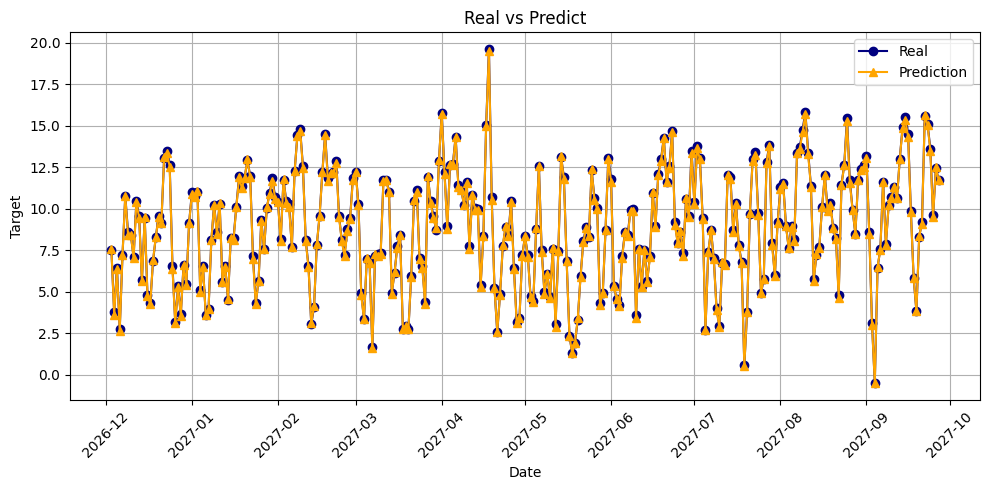

In [30]:
import matplotlib.pyplot as plt

# Temporal graph result
plt.figure(figsize=(10, 5))
plt.plot(test['date'], test['target'], marker='o', linestyle='-', label='Real', color='navy')
plt.plot(test['date'], loaded_model.predict(test), marker='^', linestyle='-', label='Prediction', color='orange')
plt.title('Real vs Predict')
plt.xlabel('Date')
plt.ylabel('Target')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()